### setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, StrMethodFormatter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from glob import glob


def mark_dup(df):
    vectorizer = TfidfVectorizer().fit_transform(df.apply(lambda x: f"{x['authors']}{x['title']}{x['abstract']}", axis=1))
    cosine_sim = cosine_similarity(vectorizer)
    threshold = 0.8
    d = []
    for i in range(len(df)):
        for j in range(i + 1, len(df)):
            if cosine_sim[i, j] >= threshold:
                d.append((df.index[i], df.index[j], cosine_sim[i, j],))
    d = pd.DataFrame(d,
          columns=['i', 'j', 'dist'])
    df = pd.merge(df.reset_index(), d[['i']], how='left', left_on='index', right_on='i')
    df = pd.merge(df, d[['j', 'i']], how='left', left_on='index', right_on='j')
    df['cosine_id'] = df.apply(lambda x: x['i_x'] if pd.isna(x['i_y']) else x['i_y'], axis=1).astype('Int64')
    df.drop(['i_x', 'i_y', 'j'], axis=1, inplace=True)
    return df

In [3]:
base_dir = './'
texts_dir = os.path.join(base_dir, "texts")
results_dir = os.path.join(base_dir, "results")

In [5]:
rw = pd.read_excel(os.path.join(results_dir, 'data_final_checked.xlsx')).reset_index()
rw = rw[['year', 'doi', 'authors', 'title', 'abstract']].copy()

In [13]:
vl = pd.read_excel(os.path.join(results_dir, 'filtered.xlsx'))\
    .reset_index().rename(columns={'ArticleType': 'type'})
vl.columns = [i.lower() for i in vl.columns]
vl['source'] = 'proquest'
vl = vl[['year', 'authors', 'title', 'abstract', 'type', 'source']].copy()

In [15]:
df = pd.concat([vl, rw])

In [16]:
d = mark_dup(df)

In [18]:
d.to_excel('vocal_dedup.xlsx')

### pipeline

In [6]:
base_dir = './'
texts_dir = os.path.join(base_dir, "texts")
results_dir = os.path.join(base_dir, "results")

In [9]:
texts = [pd.read_excel(i) for i in glob(os.path.join(texts_dir, "*.xls"))]
texts = pd.concat(texts)
print(f'N = {texts.shape[0]}')
texts = texts[texts['language'].str.contains('English')]
n = texts.shape[0]
print(f'n = {n} (language)')
texts = texts[~texts['ArticleType'].str.contains('Scholarly Journals')].reset_index(drop=True)
n = texts.shape[0]
print(f'n = {n} (article type)')
texts['store_id'] = texts['StoreId']

N = 3000
n = 2985 (language)
n = 1466 (article type)


In [11]:
MODELS

['llama3.3:70b', 'deepseek-r1:70b', 'gpt-oss:120b', 'qwen3:235b']

In [ ]:
i = df_raw[df_raw['Source'] == 'Scopus'].shape[0]
j = len(df_raw) - i
print(f"scopus: {i}, other: {j}, total: {i+j}")

scopus: 2152, other: 787, total: 2939


In [ ]:
df_topic = df_raw[pd.to_numeric(df_raw['outoftopic'] != 1)]
print(f"{len(df_raw)} - {len(df_raw) - len(df_topic)} = {len(df_topic)}")

2939 - 2445 = 494


In [ ]:
df_dedup = mark_dup(df_topic)
df_dedup.to_excel('/content/drive/MyDrive/review/dedup_data.xlsx')

In [ ]:
df_dedup = pd.read_excel('/content/drive/MyDrive/review/scaned_dedup_data.xlsx')
df_dedup = df_dedup[pd.to_numeric(df_dedup['duplicated'] != 1) & pd.to_numeric(df_dedup['year'] >= 2015)]
print(f"{len(df_topic)} - {len(df_topic) - len(df_dedup)} = {len(df_dedup)}")

494 - 115 = 379


In [ ]:
df_dedup['type'] = df_dedup['type'].str.lower()
df_dedup['Repository'] = df_dedup['Repository'].str.lower()
df_dedup['type'].value_counts()

,count
type,
conference paper,199
article,122
preprint,56
review,1
book chapter,1


In [ ]:
df_type = df_dedup[df_dedup['type'].apply(lambda x: x not in ['conference review',
                                                     'retracted', 'note',
                                                     'editorial', 'review', 'book chapter'])]
print(f"{len(df_dedup)} - {len(df_dedup) - len(df_type)} = {len(df_type)}")

379 - 2 = 377


In [ ]:
df_type.value_counts(subset='Repository')

,count
Repository,
arxiv,52
ssrn,3
research square,1


In [ ]:
df_type['Source'].str.lower().fillna('other').value_counts()

,count
Source,
scopus,321
other,56


In [ ]:
df_type.to_excel('/content/drive/MyDrive/review/cat_data.xlsx', index=False)

### categorization

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/review/data_final_checked.xlsx').reset_index()
df['ln_cat'] = df.apply(lambda x: 'Lightning' in str(x['protocols_mentioned'])  or 'LN' in str(x['code_2']), axis=1)
df['code_2'] = df['ln_cat'].apply(lambda x: 'LN' if x else 'Other')
cleaned = df[['year', 'doi', 'authors', 'title', 'abstract', 'code_0', 'code_1', 'code_2']].copy()
cleaned.reset_index(drop=True).to_csv('/content/drive/MyDrive/review/cleaned.csv', sep=';')
df_cat = pd.read_excel('/content/drive/MyDrive/review/scaned_cat_data.xlsx')
print(f"{len(df_cat)} - {len(df_cat) - len(df)} = {len(df)}")

377 - 64 = 313


In [ ]:
df['source'].str.lower().fillna('other').value_counts()

,count
source,
scopus,266
arxiv,42
ssrn,3
research square,2


In [ ]:
for c0 in df.code_0.dropna().drop_duplicates():
    for c1 in df.code_1.dropna().drop_duplicates():
        print(c0, c1)
        s = df[(df['code_0'] == c0) & (df['code_1'] == c1)]
        print(', '.join(s.paper_id.apply(lambda x: "R" + str(x).zfill(3)).to_list()))
        print()

New Protocol Security
R000, R004, R010, R015, R020, R029, R030, R032, R043, R044, R045, R046, R051, R057, R063, R068, R070, R074, R092, R096, R112, R116, R125, R129, R135, R145, R147, R164, R165, R166, R167, R179, R189, R193, R195, R203, R208, R215, R217, R224, R229, R234, R237, R238, R255, R263, R275, R284, R286, R299, R302, R327, R328, R333, R335, R339, R340, R343, R344, R347, R351, R357, R361, R365, R366, R377, R378

New Protocol Performance
R002, R005, R013, R017, R018, R019, R041, R052, R071, R072, R075, R088, R089, R090, R091, R099, R101, R104, R108, R109, R113, R123, R127, R130, R138, R139, R140, R142, R146, R148, R153, R159, R160, R169, R170, R171, R173, R174, R175, R178, R184, R197, R198, R200, R211, R218, R220, R226, R228, R231, R249, R250, R251, R259, R271, R274, R285, R288, R292, R293, R294, R308, R315, R322, R323, R324, R330, R332, R338, R341, R350, R355, R359, R363, R367, R371, R374, R375, R376

New Protocol Economics
R012, R024, R037, R048, R055, R056, R100, R152, R157, 

In [ ]:
s = df[pd.notna(df['use_ml'])]
print(', '.join(s.paper_id.apply(lambda x: "R" + str(x).zfill(3)).to_list()))

R113, R157, R161, R174, R178, R242, R274, R278, R279, R306, R308, R310, R320, R324, R325, R361, R372, R379, R380


In [ ]:
s = df[pd.notna(df['new_software'])]
print(', '.join(s.paper_id.apply(lambda x: "R" + str(x).zfill(3)).to_list()))

R011, R012, R019, R103, R187, R228, R269, R280, R281, R300, R301, R303, R371, R380, R381, R382


In [ ]:
bv = pd.read_csv('/content/drive/MyDrive/review/bvisuals.csv', sep=';', parse_dates=True)
bv['datetime'] = pd.to_datetime(bv['datetime'])
bv.set_index('datetime', inplace=True)
bv = bv[['nodes']].resample('YE').mean()
bv.index = pd.Series(bv.index).apply(lambda x: int(str(x)[:4]))

      articles  preprints         nodes
2015         2        NaN           NaN
2016         1        1.0           NaN
2017         3        2.0           NaN
2018         9        2.0   1752.982709
2019        19        3.0   4330.049315
2020        34       10.0   6310.680328
2021        29        5.0  13129.106443
2022        45        9.0  17920.458564
2023        43        1.0  17516.622590
2024        60        6.0  15948.933579
2025        21        8.0   9514.000000
articles        24.181818
preprints        4.700000
nodes        10802.854191
dtype: float64


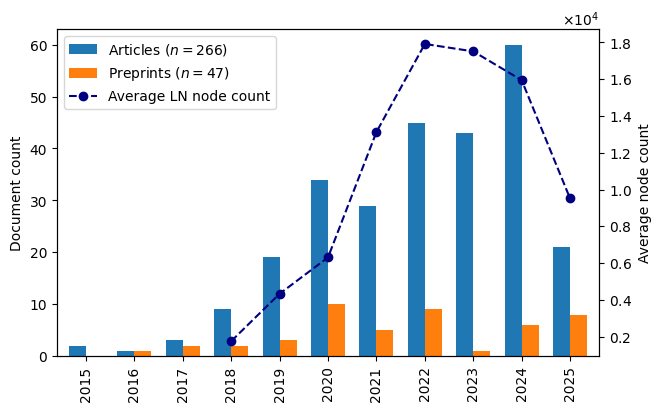

In [ ]:
s = df[df["source"] == 'scopus'][['index', 'year']].groupby('year').count().rename(columns={'index':'articles'})
p = df[df["source"] != 'scopus'][['index', 'year']].groupby('year').count().rename(columns={'index':'preprints'})
fig, ax = plt.subplots(figsize=(6.5, 4), layout='constrained')
d = pd.merge(s, p, left_index=True, right_index=True, how='outer')
d = pd.merge(d, bv, left_index=True, right_index=True, how='outer')
print(d)
print(d.mean())
d[['articles', 'preprints']].plot(ax=ax, kind='bar', width=0.7, legend=False)
h, l = ax.get_legend_handles_labels()
ax.set_xlabel(None)
ax.set_ylabel('Document count')

ax1 = ax.twinx()
d[['nodes']].plot(ax=ax1, kind='line', linestyle='--',
                  marker='o', use_index=False, color='navy', legend=False)
xfmt = ScalarFormatter(useMathText=True)
xfmt.set_powerlimits((0,0))
ax1.yaxis.set_major_formatter(xfmt)
h1, l1 = ax1.get_legend_handles_labels()
ax1.legend(h + h1, [f"Articles ($n={s.articles.sum()}$)",
                    f"Preprints ($n={p.preprints.sum()}$)",
                    "Average LN node count"])
ax1.set_xlabel(None)
ax1.set_ylabel('Average node count')
#plt.tight_layout()
plt.show()
#fig.savefig('fig02.png', dpi=1200, format='png', bbox_inches='tight', pad_inches=0.5)
fig.savefig('fig02.pdf', dpi=1200, format='pdf', bbox_inches='tight', pad_inches=0.5)

In [ ]:
df_counts = df.groupby(['code_0', 'code_1']).size().reset_index(name='value')
df_counts['code_0'] = df_counts['code_0']\
                        .str.replace(' ', '')\
                        .str.replace('P', 'p')\
                        .str.replace('Modified', 'Modified   \n')\
                        .str.replace('New', 'New      \n')
hv.Sankey(df_counts, kdims=["code_0", "code_1"], vdims=hv.Dimension('value',
          value_format=lambda x: f"\n{x} ({x*100/df_counts.value.sum():.1f}%)"))\
          .opts(opts.Sankey(
              #show_values=False,
              width=600, height=400,
              edge_color='code_0',
              label_position='outer',
              tools=['hover'],
    )
)

:Sankey   [code_0,code_1]   (value)

/tmp/ipython-input-99193058.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


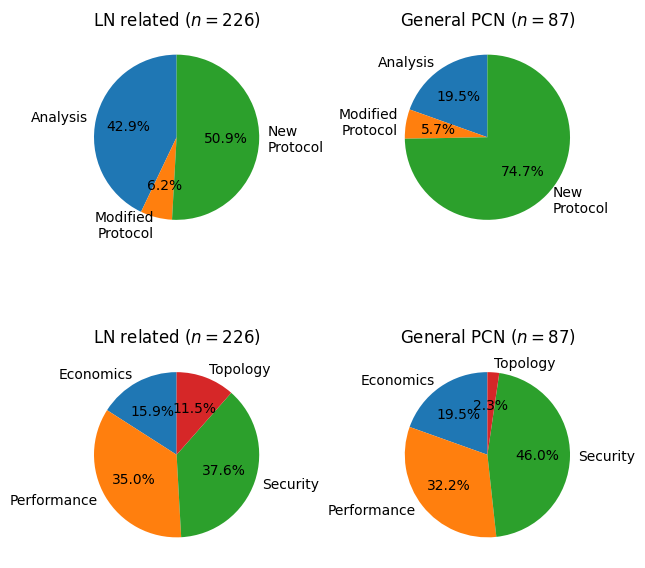

In [ ]:
d = df.copy()
d['code_0'] = d['code_0']\
        .str.replace('Modified', ' Modified\n')\
        .str.replace('New', 'New\n')\
        .str.replace(' ', '')
d['ln_cat'] = d.apply(lambda x: 'Lightning' in str(x['protocols_mentioned'])  or 'LN' in str(x['code_2']), axis=1)
a1 = d[d["ln_cat"]].groupby(['code_0']).size().reset_index(name='value')
a2 = d[~d["ln_cat"]].groupby(['code_0']).size().reset_index(name='value')
b1 = d[d["ln_cat"]].groupby(['code_1']).size().reset_index(name='value')
b2 = d[~d["ln_cat"]].groupby(['code_1']).size().reset_index(name='value')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(6.5, 6.5), layout='constrained')
ax1.pie(a1.value, labels=a1.code_0, autopct='%1.1f%%', startangle=90)
ax1.set_title(f'LN related ($n={a1.value.sum()}$)')
ax2.pie(a2.value, labels=a2.code_0, autopct='%1.1f%%', startangle=90)
ax2.set_title(f'General PCN ($n={a2.value.sum()}$)')

ax3.pie(b1.value, labels=b1.code_1, autopct='%1.1f%%', startangle=90)
ax3.set_title(f'LN related ($n={b1.value.sum()}$)')
ax4.pie(b2.value, labels=b2.code_1, autopct='%1.1f%%', startangle=90)
ax4.set_title(f'General PCN ($n={b2.value.sum()}$)')

plt.tight_layout()
plt.show()
#fig.savefig('fig04.png', dpi=1200, format='png', bbox_inches='tight', pad_inches=0.5)
fig.savefig('fig04.pdf', dpi=1200, format='pdf', bbox_inches='tight', pad_inches=0.5)

/tmp/ipython-input-2862391674.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


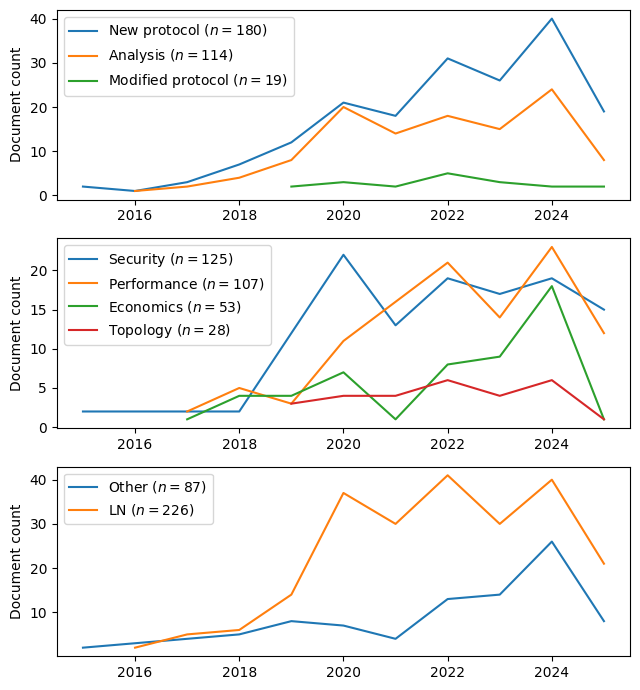

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(6.5, 7), layout='constrained')
for c in df.code_0.dropna().drop_duplicates():
    d = df[df['code_0'] == c].groupby('year').size()\
          .reset_index(name=f"{str(c).replace('Pr', 'pr')} ($n={(df['code_0'] == c).sum()}$)")\
          .set_index('year')
    d.plot(ax=axs[0], kind='line')

for c in df.code_1.dropna().drop_duplicates():
    d = df[df['code_1'] == c].groupby('year').size()\
          .reset_index(name=f"{str(c)} ($n={(df['code_1'] == c).sum()}$)")\
          .set_index('year')
    d.plot(ax=axs[1], kind='line')

for c in df.code_2.dropna().drop_duplicates():
    d = df[df['code_2'] == c].groupby('year').size()\
          .reset_index(name=f"{str(c)} ($n={(df['code_2'] == c).sum()}$)")\
          .set_index('year')
    d.plot(ax=axs[2], kind='line')

axs[0].set_ylabel('Document count')
axs[1].set_ylabel('Document count')
axs[2].set_ylabel('Document count')

axs[0].set_xlabel(None)
axs[1].set_xlabel(None)
axs[2].set_xlabel(None)

plt.tight_layout()
plt.show()
#fig.savefig('fig05.png', dpi=1200, format='png', bbox_inches='tight', pad_inches=0.5)
fig.savefig('fig05.pdf', dpi=1200, format='pdf', bbox_inches='tight', pad_inches=0.5)

In [ ]:
def _getn(x):
    x = str(x).split('n=')
    if len(x) > 1:
        x = x[1]
        if ',' in x:
            x = x.split(',')[0]
        return int(x)
df['ln_max_size_n'] = df['max_size'].apply(_getn).astype('Int64')
df['ripple_max_size_n'] = df['max_size_ripple'].apply(_getn).astype('Int64')

def _getc(x):
    x = str(x).split('c=')
    if len(x) > 1:
        x = x[1]
        if ',' in x:
            x = x.split(',')[0]
        return int(x)
df['ln_max_size_c'] = df['max_size'].apply(_getc).astype('Int64')
df['ripple_max_size_c'] = df['max_size_ripple'].apply(_getc).astype('Int64')

In [ ]:
a = df[df['code_0'] != 'Analysis']
b = df[df['code_0'] == 'Analysis']
aa = a['snapshot_use'].fillna(0).astype(bool).value_counts() / len(df) * 100
bb = b['snapshot_use'].fillna(0).astype(bool).value_counts() / len(df) * 100
print(aa)
print(bb)

snapshot_use
False    44.089457
True     19.488818
Name: count, dtype: float64
snapshot_use
False    19.488818
True     16.932907
Name: count, dtype: float64


/tmp/ipython-input-3191012375.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  aa = a['snapshot_use'].fillna(0).astype(bool).value_counts() / len(df) * 100


In [ ]:
a = df[df['code_0'] != 'Analysis']
b = df[df['code_0'] == 'Analysis']
aa = a['complexity_measures'].fillna(0).astype(bool).value_counts() / len(df) * 100
bb = b['complexity_measures'].fillna(0).astype(bool).value_counts() / len(df) * 100
print(aa)
print(bb)

complexity_measures
False    49.520767
True     14.057508
Name: count, dtype: float64
complexity_measures
False    33.546326
True      2.875399
Name: count, dtype: float64


/tmp/ipython-input-1480739287.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dd = d[d['snapshot_use'].fillna(0).astype(bool)]
/tmp/ipython-input-1480739287.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dd = d[~d['snapshot_use'].fillna(0).astype(bool)]
/tmp/ipython-input-1480739287.py:38: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


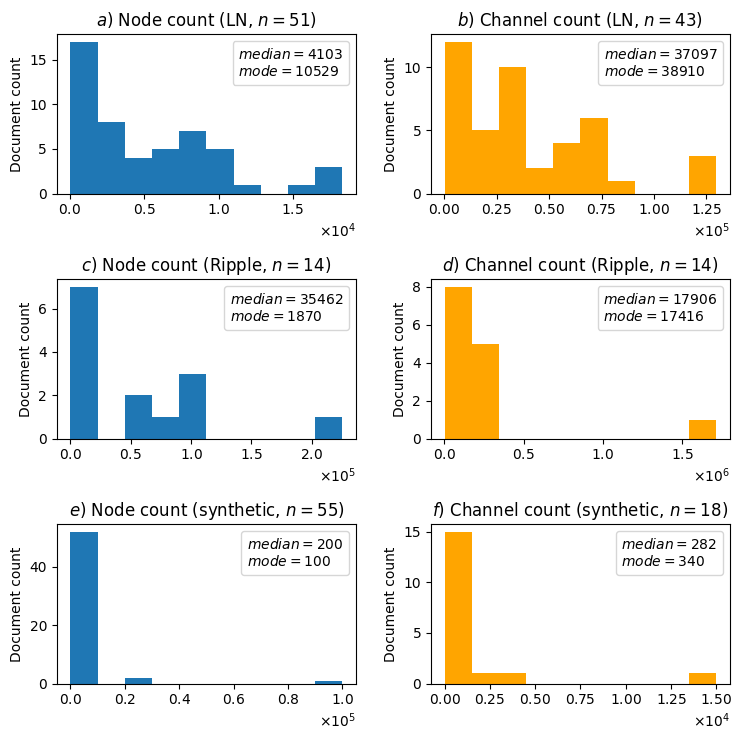

In [ ]:
fig, ((ax1, ax2),
      (ax3, ax4),
      (ax5, ax6)) = plt.subplots(3, 2, figsize=(7.5, 7.5), layout='constrained')
d = df[df['code_0'] != 'Analysis'].copy()
dd = d[d['snapshot_use'].fillna(0).astype(bool)]

def l_(ax, s, t='Node count'):
  leg = ax.legend([f"$median = {s.median():.0f}$\n$mode = {s.mode()[0]:.0f}$"], #$mean = {s.mean():.0f}$\n
            handlelength=0, handletextpad=0, fancybox=True)
  for item in leg.legend_handles:
      item.set_visible(False)
  xfmt = ScalarFormatter(useMathText=True)
  xfmt.set_powerlimits((0,0))
  ax.xaxis.set_major_formatter(xfmt)
  ax.set_ylabel('Document count')
  ax.set_title(t)

ax1.hist(dd.ln_max_size_n)
l_(ax1, dd.ln_max_size_n, f'$a$) Node count (LN, $n={len(dd.ln_max_size_n.dropna())}$)')

ax2.hist(dd.ln_max_size_c, color='orange')
l_(ax2, dd.ln_max_size_c, f'$b$) Channel count (LN, $n={len(dd.ln_max_size_c.dropna())}$)')

ax3.hist(dd.ripple_max_size_n)
l_(ax3, dd.ripple_max_size_n, f'$c$) Node count (Ripple, $n={len(dd.ripple_max_size_n.dropna())}$)')

ax4.hist(dd.ripple_max_size_c, color='orange')
l_(ax4, dd.ripple_max_size_c, f'$d$) Channel count (Ripple, $n={len(dd.ripple_max_size_c.dropna())}$)')

dd = d[~d['snapshot_use'].fillna(0).astype(bool)]

ax5.hist(dd.ln_max_size_n)
l_(ax5, dd.ln_max_size_n, f'$e$) Node count (synthetic, $n={len(dd.ln_max_size_n.dropna())}$)')

ax6.hist(dd.ln_max_size_c, color='orange')
l_(ax6, dd.ln_max_size_c, f'$f$) Channel count (synthetic, $n={len(dd.ln_max_size_c.dropna())}$)')

plt.tight_layout()
plt.show()

#fig.savefig('fig06.png', dpi=1200, format='png', bbox_inches='tight', pad_inches=0.5)
fig.savefig('fig06.pdf', dpi=1200, format='pdf', bbox_inches='tight', pad_inches=0.5)

In [ ]:
d = df[df['code_0'] != 'Analysis'].copy()
dd = d[~d['snapshot_use'].fillna(0).astype(bool)]
print('nodes')
for c in dd.code_1.dropna().drop_duplicates():
    ddd = dd[dd['code_1'] == c]
    s = ddd.ln_max_size_n
    print(f"{c}\n$median = {s.median():.0f}$, $mode = {s.mode()[0]:.0f}$")

print('\nchannels')
for c in dd.code_1.dropna().drop_duplicates():
    ddd = dd[dd['code_1'] == c]
    s = ddd.ln_max_size_c
    try:
      print(f"{c}\n$median = {s.median():.0f}$, $mode = {s.mode()[0]:.0f}$")
    except:
      pass

print('\nnodes, topology or economics')
ddd = dd[(dd['code_1'] == 'Topology') | (dd['code_1'] == 'Economics')]
s = ddd.ln_max_size_n
print(f"$median = {s.median():.0f}$, $mode = {s.mode()[0]:.0f}$")

print('\nchannels, topology or economics')
ddd = dd[(dd['code_1'] == 'Topology') | (dd['code_1'] == 'Economics')]
s = ddd.ln_max_size_c
print(f"$median = {s.median():.0f}$, $mode = {s.mode()[0]:.0f}$")

nodes
Security
$median = 30$, $mode = 5$
Performance
$median = 250$, $mode = 100$
Economics
$median = 200$, $mode = 1$
Topology
$median = 215$, $mode = 128$

channels
Security
$median = 2010$, $mode = 20$
Performance
$median = 300$, $mode = 340$
Economics
$median = 50$, $mode = 2$

nodes, topology or economics
$median = 200$, $mode = 1$

channels, topology or economics
$median = 50$, $mode = 2$


/tmp/ipython-input-311393419.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dd = d[~d['snapshot_use'].fillna(0).astype(bool)]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


/tmp/ipython-input-2644935045.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


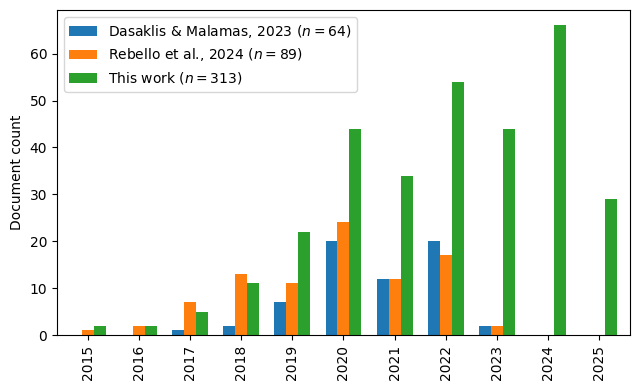

In [ ]:
ref = pd.DataFrame({'year': [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025],
                     'ref212': [0, 0, 1, 2, 7, 20, 12, 20, 2, 0, 0], # Dasaklis2023 212
                     'ref307': [1, 2, 7, 13, 11, 24, 12, 17, 2, 0, 0], # Rebello2024 307
                     'our': df[['index', 'year']].groupby('year').count()['index'].to_list(),
                    })
ref_sum = ref.sum()
fig, ax = plt.subplots(figsize=(6.5, 4), layout='constrained')
ref.set_index('year').plot(ax=ax, kind='bar', width=0.7)
plt.xlabel(None)
plt.ylabel('Document count')
plt.legend([f"Dasaklis & Malamas, 2023 ($n={ref_sum.ref212.sum()}$)",
            f"Rebello et al., 2024 ($n={ref_sum.ref307.sum()}$)",
            f"This work ($n={ref_sum.our.sum()}$)"])
plt.tight_layout()
plt.show()
#fig.savefig('fig07.png', dpi=1200, format='png', bbox_inches='tight', pad_inches=0.5)
fig.savefig('fig07.pdf', dpi=1200, format='pdf', bbox_inches='tight', pad_inches=0.5)

In [ ]:
d = df[df['code_1'] == 'Topology'].sort_values(by='year', ascending=False)#.iloc[:20]
txt = []
for idx, item in d.iterrows():
    txt.append(f"ref: R{item['paper_id']}\n{item['abstract']}")

In [ ]:
txt

In [ ]:
(df.performance_measures.dropna().shape[0],
df.performance_measures.dropna().shape[0] / df.shape[0])

(157, 0.5015974440894568)

In [ ]:
df[df['code_0'] != 'Analysis'].shape[0]

199

In [ ]:
(df[df['code_0'] != 'Analysis'].performance_measures.dropna().shape[0],
df[df['code_0'] != 'Analysis'].performance_measures.dropna().shape[0] / df[df['code_0'] != 'Analysis'].shape[0] )

(134, 0.6733668341708543)

In [ ]:
perf_metrics = pd.read_excel('/content/drive/MyDrive/review/perf_metrics_group.xlsx')
perf_metrics = perf_metrics.groupby("group")\
                            .agg({'count': 'sum',
                                  'term': lambda x: ', '.join(x.to_list())})\
                                          .sort_values(by='count', ascending=False)
perf_metrics["count"] = (perf_metrics["count"] / perf_metrics["count"].sum() * 100).round(1)
perf_metrics.to_excel('perf_metrics_sorted.xlsx')
perf_metrics

,count,term
group,,
1,37.4,"success rate, payment attempts, successful pay..."
3,33.5,"execution time, latency, delay, computation ti..."
5,10.9,"communication overhead, message count, packet ..."
2,10.5,"path length, hop count"
4,7.8,"gas, FLOPs, hash computations, memory used, op..."


In [ ]:
np.random.seed(13)
wordcloud = WordCloud(width=700, height=1000, prefer_horizontal=0.5,
                      background_color="white", mode='RGBA')
freq = pd.Series(', '.join(df.performance_measures.dropna().to_list()).split(', ')).value_counts()
wordcloud.generate_from_frequencies(freq)
wordcloud.to_image().save('cloud.png', optimize=True)

(np.float64(-0.5), np.float64(699.5), np.float64(999.5), np.float64(-0.5))

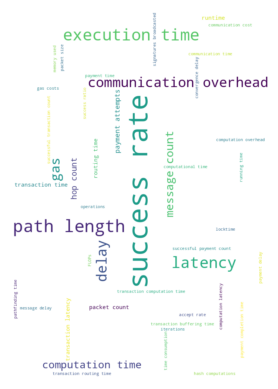

In [ ]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")